# Using neurolib for MEG-Data

In this example we will learn how to use `neurolib` to simulate resting MEG-Data. 

In the first part of the notebook we will compute the frequency specific functional connectivity matrix of an example the resting state MEG-Dataset. To this end we will: 

* Load the MEG-Data
* Band-Pass filter the signal 
* Apply the `hilbert`-transformation to extract the signal envelope
* Orthogonalize the signal envelopes of two examplary regions
* Low-Pass filter the signal envelopes
* Compute the functional connectivity matrix

In the second part of this notebook we will than use `neurlib`to simulate the brain activity and finally compute the functional connectivity matrix of the simulated signal envelope.


In [1]:
from neurolib.utils.signal import Signal 
import mat73, os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.utils import io
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import pandas as pd

# Load MEG-Data

In [136]:
# We start with a matlab file
datafile = os.path.join('data', 'test_94.mat')
data = mat73.loadmat(datafile)
time = data['AAL94_norm']['time'][0]
region_labels = np.array(data['AAL94_norm']['label'])[:,0]
nr_regions = len(region_labels)
signal_array = data['AAL94_norm']['trial'][0] 

# Create xr DataArray
signal_array = xr.DataArray(signal_array, dims=("regions", "time"), 
                      coords={"regions": region_labels, "time": time}, 
                      attrs={'atlas':'AAL2'})

In [3]:
print('Select a region from the AAL2 atlas and a frequency range')

# Select a Region 
target = widgets.Select(options=region_labels, value='PreCG.L', description='Regions', 
                        tooltips=['Description of slow', 'Description of regular', 'Description of fast'], 
                        layout=widgets.Layout(width='50%', height='150px'))
display(target)

# Select Frequency Range
freq = widgets.IntRangeSlider(min=1, max=46, description='Frequency (Hz)', value=[8, 12], layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
display(freq)

Select a region from the AAL2 atlas and a frequency range


Select(description='Regions', layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.R', 'SFG.…

IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=46, min=1, style=S…

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 165 samples (1.650 sec)



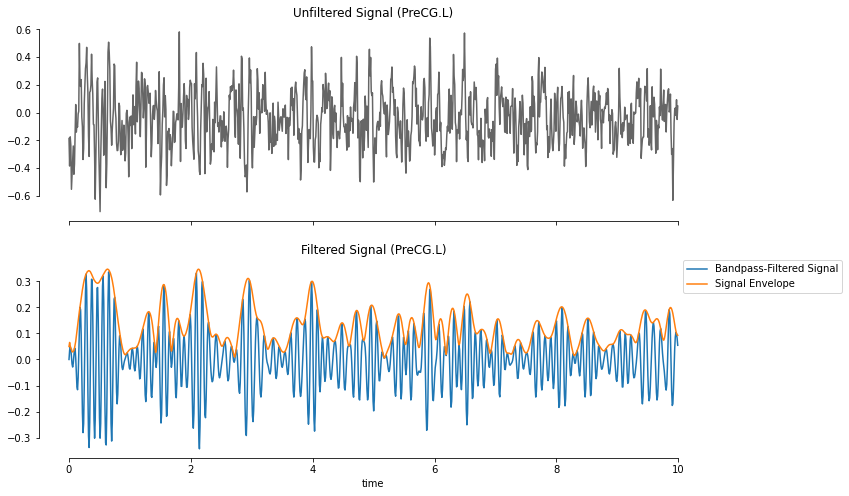

In [4]:
# Load into neurolib signal class
signal = Signal(signal_array)

# Downsample the Signal
signal.resample(to_frequency=100)

# Plot unfiltered Signal
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
sns.lineplot(x=signal.data.time[:1000], y=signal.data.sel(regions=target.value)[:1000], ax=ax[0], color='k', alpha=0.6)
ax[0].set_title(f'Unfiltered Signal ({target.value})');

# Band Pass Filter the Signal
signal.filter(freq.value[0], freq.value[1], inplace=True);

# Apply hilbert-transform to extract the signal envelope
complex_signal = signal.hilbert_transform('complex', inplace=False)
signal_env = np.abs(complex_signal.data)

# Plot filtered Signal and Signal Envelope
sns.lineplot(x=signal.data.time[:1000], y=signal.data.sel(regions=target.value)[:1000], 
             ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=signal_env.time[:1000], y=signal_env.sel(regions=target.value)[:1000], 
             ax=ax[1], label='Signal Envelope')
ax[1].set_title(f'Filtered Signal ({target.value})');
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
sns.despine(trim=True)

# Orthogonalized Signal Envelope

The main methodological issue of MEG regarding the analysis of the cortical
functional connectivity structure is its low spatial resolution, i.e. the electric field
generated by given neural source spreads widely over the cortex. So that the signal which is captured at the MEG sensors is a complex mixture of signals from multiple underlying neural sources.

To account for the effect of electrict field spread on our MEG connectivity measures we adapted the work of `Hipp et al., 2012`.

The basic idea behind this approach is that a signal which is generated by one neural source and is measured at two separate sensors must have exactly the same phase at both sensors. In contrast, signals from different neural sources have different phases. And thus it is possible to eliminate the effect of a reference signal on the target signal by removing the signal component, that has the same phase as a reference region.

In [5]:
print('Select a reference region for the orthogonalization')
# Select a Region 
referenz = widgets.Select(options=region_labels, value='PreCG.R', description='Regions',
                          tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
                          layout=widgets.Layout(width='50%', height='150px'))
display(referenz)

Select a reference region for the orthogonalization


Select(description='Regions', index=1, layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.…

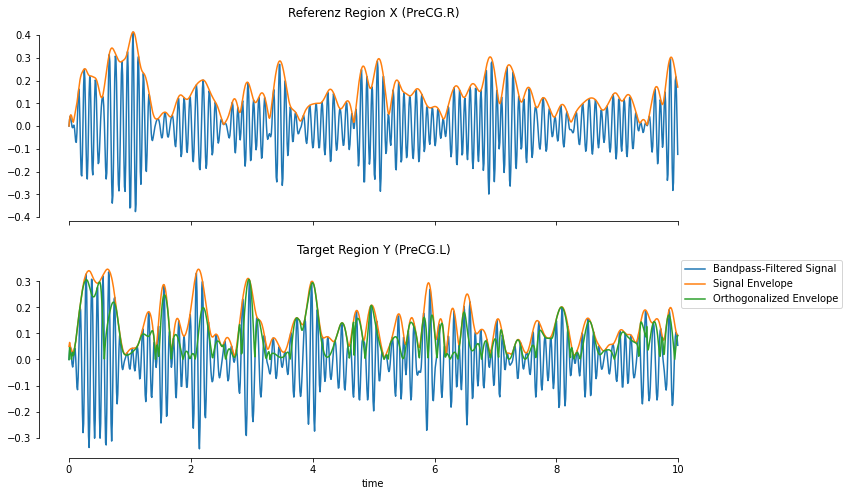

In [6]:
# Perform Orthogonalization
signal_conj = complex_signal.data.conj()
conj_div_env = signal_conj/signal_env
orth_signal = (complex_signal.data.sel(regions=target.value) * conj_div_env.sel(regions=referenz.value)).imag
orth_env = np.abs(orth_signal)

# Plot 
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
sns.lineplot(x=signal.data.time[:1000], y=signal.data.sel(regions=referenz.value)[:1000], ax=ax[0])
sns.lineplot(x=signal_env.time[:1000], y=signal_env.sel(regions=referenz.value)[:1000], ax=ax[0])
ax[0].set_title(f'Referenz Region X ({referenz.value})');
sns.lineplot(x=signal.data.time[:1000], y=signal.data.sel(regions=target.value)[:1000], ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=signal_env.time[:1000], y=signal_env.sel(regions=target.value)[:1000], ax=ax[1], label='Signal Envelope')
sns.lineplot(x = orth_env.time[:1000], y=orth_env[:1000], ax=ax[1], label='Orthogonalized Envelope')
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax[1].set_title(f'Target Region Y ({target.value})');
sns.despine(trim=True)

## Low-Pass Filter the Envelopes

In [7]:
low_pass = widgets.FloatSlider(value=0.2, min=0, max=2.0, step=0.1, description='Low-Pass Frequency (Hz)', 
                               disabled=False, readout=True, readout_format='.1f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(low_pass)

FloatSlider(value=0.2, description='Low-Pass Frequency (Hz)', layout=Layout(width='80%'), max=2.0, readout_for…

Orthogonalized envelope correlation between PreCG.R and PreCG.L:  0.07


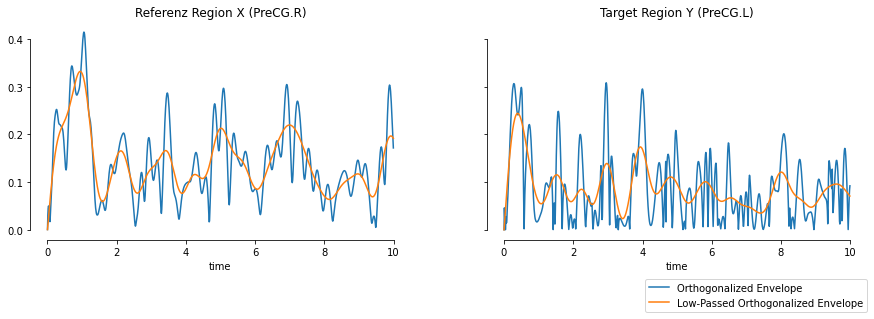

In [8]:
with io.capture_output() as captured:
    low_orth_env = Signal(orth_env).filter(low_freq=None, high_freq=low_pass.value, inplace=False)
    low_signal_env = Signal(signal_env.sel(regions=referenz.value)).filter(low_freq=None, high_freq=low_pass.value, inplace=False)

# Plot
fig, ax = plt.subplots(1,2,figsize=(15,4), sharey=True)
sns.lineplot(x=signal_env.time[:1000], y=signal_env.sel(regions=referenz.value)[:1000], ax=ax[0])
sns.lineplot(x=low_signal_env.data.time[:1000], y=low_signal_env.data[:1000], ax=ax[0])
ax[0].set_title(f'Referenz Region X ({referenz.value})');
sns.lineplot(x = orth_env.time[:1000], y=orth_env[:1000], ax=ax[1], label='Orthogonalized Envelope')
sns.lineplot(x = low_orth_env.data.time[:1000], y=low_orth_env.data[:1000], ax=ax[1], label='Low-Passed Orthogonalized Envelope')
ax[1].legend(bbox_to_anchor=(1, -0.18),borderaxespad=0)
ax[1].set_title(f'Target Region Y ({target.value})');
sns.despine(trim=True)
print(f'Orthogonalized envelope correlation between {referenz.value} and {target.value}: ', np.round(np.corrcoef(low_orth_env.data,low_signal_env.data)[0,1],2))

## Compute the Functional Connectivity Matrix


We use a function that orthogonalizes and correlates each pair of signal envelopes. 
Since the orthogonlization is not symmetric we take the mean of two pairwise correlation value for the final connectivity matrix.

In [9]:
def orth_fc(signal, low_pass):     
    progress = widgets.IntProgress(min=0, max=nr_regions, description=('Calculating FC Matrix'),
                                   layout=widgets.Layout(width='80%'), style={'description_width': 'initial'})
    display(progress)

    complex_signal = signal.hilbert_transform('complex', inplace=False)
    signal_env = signal.hilbert_transform('amplitude', inplace=False);
    conj_div_env = complex_signal.data.conj()/signal_env.data    
    
    # Low-pass filter Signal envelope
    with io.capture_output() as captured:
        signal_env.filter(low_freq=None, high_freq=low_pass)
    
    corr = []
    for complex_region in complex_signal.data: 
        orth_signal = (complex_region * conj_div_env).imag
        orth_env = np.abs(orth_signal).T
        orth_env = Signal(orth_env)
        with io.capture_output() as captured:
            orth_env.filter(low_freq=None, high_freq=low_pass)
        corr_mat = np.corrcoef(orth_env.data, signal_env.data)
        corr.append(np.diag(corr_mat, k=nr_regions))
        progress.value += 1

    fc = np.array(corr)
    fc = (fc.T + fc) / 2.
    np.fill_diagonal(fc,0)
    return fc

# Execute Function
fc = orth_fc(signal, low_pass.value)

IntProgress(value=0, description='Calculating FC Matrix', layout=Layout(width='80%'), max=94, style=ProgressSt…

Let's now plot the functional connectivity matrix. We label only every second row/column since right and left regions alternate in the AAL2 atlas.

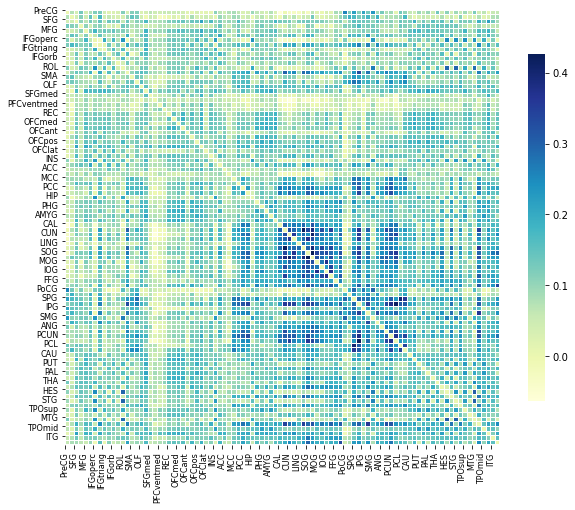

In [135]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fc, square=True, ax=ax, cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .8})
ticks = [tick[:-2] for tick in region_labels[::2]]
ax.set_xticks(np.arange(0,94,2)); ax.set_yticks(np.arange(0,94,2))    
ax.set_xticklabels(ticks, rotation=90, fontsize=8); ax.set_yticklabels(ticks, rotation=0, fontsize=8);
np.save('meg_fc.npy',fc)

#### Exclude subcortical regions
For the following whole-brain simulation we are only interested in the cortical regions. So we'll now exclude all subcortical regions: 
* Hippocampus: 41 - 44
* Amygdala: 45-46
* Basal Ganglia: 75-80
* Thalamus: 81-82

> Attention: AAL indices start with 1

In [11]:
exclude = list(range(40, 46)) + list(range(74, 82))
tmp = np.delete(fc, exclude, axis=0)
emp_fc = np.delete(tmp, exclude, axis=1)
# Exclude regions from the list of region labels
emp_labels = np.delete(region_labels, exclude)

# Simulation using Neurolib

In [203]:
global_coupling = widgets.FloatSlider(value=3.8, min=0., max=5.0, step=0.01, description='Global Coupling', 
                               disabled=False, readout=True, readout_format='.2f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
exc_drive = widgets.FloatSlider(value=0.7, min=0.45, max=0.9, step=0.01, description='Exc. Background Drive', 
                               disabled=False, readout=True, readout_format='.2f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
noise_level = widgets.FloatSlider(value=0.017, min=0.001, max=0.05, step=0.0001, description='Noise Level', 
                               disabled=False, readout=True, readout_format='.3f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(global_coupling)
display(exc_drive)
display(noise_level)

FloatSlider(value=3.8, description='Global Coupling', layout=Layout(width='80%'), max=5.0, step=0.01, style=Sl…

FloatSlider(value=0.7, description='Exc. Background Drive', layout=Layout(width='80%'), max=0.9, min=0.45, ste…

FloatSlider(value=0.017, description='Noise Level', layout=Layout(width='80%'), max=0.05, min=0.001, readout_f…

In [204]:
# Let's import the neurolib
from neurolib.models.wc import WCModel
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func

# First we load the structural data set from the Human Connectome Project 
ds = Dataset("hcp")

# We initiate the Wilson-Cowan model
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
wc.params['duration'] = 1*60*1000 
wc.params['K_gl'] = global_coupling.value
wc.params['exc_ext'] = np.repeat(exc_drive.value,80)
wc.params['sigma_ou'] = noise_level.value

In [205]:
# We set the random seed and run the model
np.random.seed(0)
wc.run(chunkwise=True, append=True)

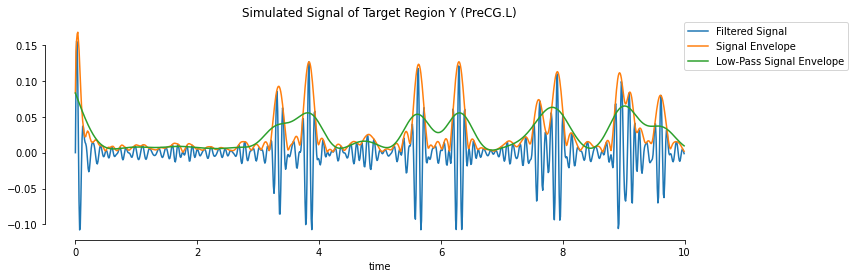

In [206]:
# Create xr DataArray from the simulated timeseries
sim_signal = xr.DataArray(wc.exc, dims=("regions", "time"), coords={"regions": emp_labels, "time": wc.t/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

# Filter signal
sim_signal = Signal(sim_signal)
sim_signal.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal = sim_signal.filter(freq.value[0], freq.value[1], inplace=False);
sns.lineplot(x=sim_signal.data.time[:1000], y=sim_signal.data.sel(regions=target.value)[:1000], ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal.data.time[:1000], y=sim_signal.data.sel(regions=target.value)[:1000], ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal.data.time[:1000], y=sim_signal.data.sel(regions=target.value)[:1000], ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

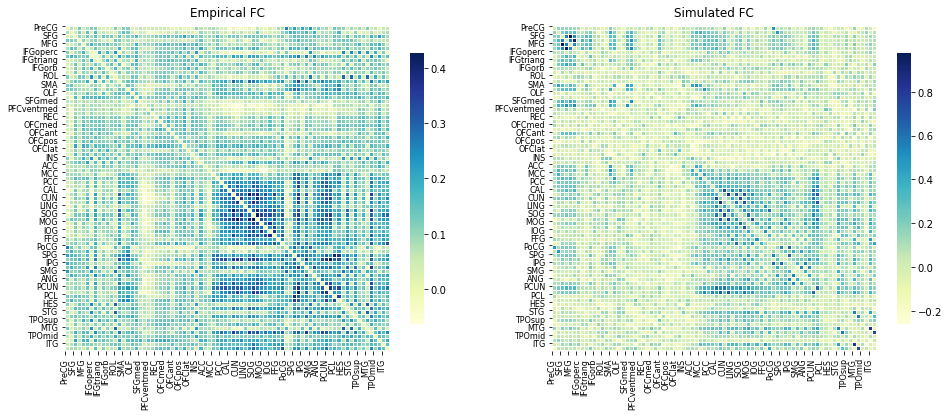

In [207]:
# Compute the functional connectivity matrix
sim_fc = func.fc(sim_signal.data)

# Set diagonal to zero
np.fill_diagonal(sim_fc, 0)

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(1,2, figsize=(16,10))
sns.heatmap(emp_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .5})
ax[0].set_title('Empirical FC',pad=10);
sns.heatmap(sim_fc, square=True, ax=ax[1], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .5})
ax[1].set_title('Simulated FC',pad=10);
ticks = [tick[:-2] for tick in emp_labels[::2]]
for ax in ax:
    ax.set_xticks(np.arange(0,80,2)); ax.set_yticks(np.arange(0,80,2))    
    ax.set_xticklabels(ticks, rotation=90, fontsize=8); ax.set_yticklabels(ticks, rotation=0, fontsize=8);

Parameters: 	Global Coupling: 3.8
		Exc. Background Drive: 0.7
		Noise Level: 0.017


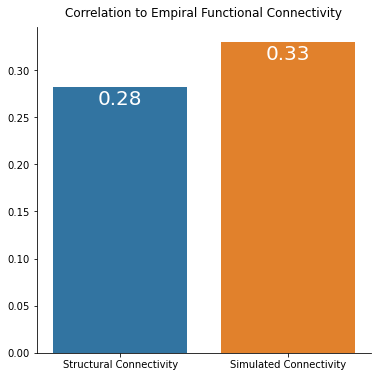

In [208]:
# Compare structural and simulated connectivity to the empirical functional connectivity
struct_emp = np.corrcoef(emp_fc.flatten(), ds.Cmat.flatten())[0,1]
sim_emp = np.corrcoef(emp_fc.flatten(), sim_fc.flatten())[0,1]

# Plot
fig, ax = plt.subplots(figsize=(6,6))
splot = sns.barplot(x=['Structural Connectivity', 'Simulated Connectivity'], y=[struct_emp, sim_emp], ax=ax)
ax.set_title('Correlation to Empiral Functional Connectivity', pad=10)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20, color='white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')
sns.despine()
print(f"Parameters: \tGlobal Coupling: {wc.params['K_gl']}\n\t\tExc. Background Drive: {wc.params['exc_ext'][0]}")
print(f"\t\tNoise Level: {wc.params['sigma_ou']}")